## Two-dimensional flows: maintaining incompressibility with a pressure solver

v2.82, 6 April 2018, by Brian Fiedler

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$
$\require{color}$

## Copied out by Brian Mapes Feb 2019 from 
## Edited by Wei-Ming Tsai Feb 2019
https://anaconda.org/bfiedler/notebooks

Don't miss the high-res precomputed result at http://12characters.net/explore/blob801i.html

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math, os
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

## The incompressible equations

The equations are those in `StreamfunctionVorticity.ipynb`: two-dimensional, inviscid, incompressible flow,
but now in the $(x,z)$ plane. 
Being incompressible, density is conserved in parcels.
But here we allow for gravity in the $z$ direction and for density to vary between parcels.
The density anomalies lead to the buoyancy term $\textcolor{red}{b}$.
In a future notebook, we will derive a justification for $\textcolor{red}b$, and discuss the non-dimensionalization.

$$
\pdt{u} + u \pd{u}{x} + v \pd{u}{y}= - \pd{P}{x}
$$

$$
\pdt{v} + u \pd{v}{x} + v \pd{v}{y}= - \pd{P}{y} + \textcolor{red}{b}
$$

$$
\delta \equiv \pd{u}{x} + \pd{v}{y}  = 0
$$

With the density anomaly conserved in a parcel, or $\ddt{b}$=0:
$$
\pdt{b} = -u \pd{b}{x} - v \pd{b}{y}
$$

## The pressure solver
As in the stream function vorticity method, we don't see any prognostic equation for $P$.
Again, we concentrate on the consequence of pressure doing its job: maintaining $\delta=0$.
But we do not solve for a stream function from a prognosticated vorticity.

To solve for pressure that maintains $\delta=0$ at each time step, 
the divergence of local acceleration should be kept close to zero at each time step:

$$ \delta=0 \quad \Rightarrow \quad
\pdt{\delta} = \pd{}{x}\pdt{u}+\pd{}{z}\pdt{w} = 0
$$

As we shall see below, at each time step, after all the accelerations (advection, buoyancy, viscosity , ...)
except a pressure-gradient force are accumlated, we seek a pressure field that gives a pressure-gradient force that will keep $\pdt{\delta}=0$.
So prior to the pressure calculation,  $\pdt{U}$ and  $ \pdt{V}$ are known.

$$
\pdt{u} = - \pd{P}{x} + \pdt{U}
$$

$$
\pdt{v} = - \pd{P}{y} + \pdt{U}
$$

We seek

$$
\pd{}{x} \pdt{u} 
+
\pd{}{y} \pdt{v}  = 0 =
- \pd{^2}{x^2}P - \pd{^2}{y^2}P
+ \pd{}{x} \pdt{U} 
+ \pd{}{y} \pdt{V}
$$

So we solve for $p(x,y)$ in this Poisson equation, with the r.h.s. known:

$$
\lapl P = 
 \pd{}{x} \pdt{U} 
+ \pd{}{y} \pdt{V}
$$

The boundary conditions for $u(x,y,t)$, $v(x,y,t)$  are that the normal component of
velocity at the boundaries is zero. If we use the default dimensionless square domain:

$$
u(0,y,t)=0 \qquad u(1,y,t)=0 \qquad v(x,0,t)=0 \qquad v(x,1,t)=0
$$

If $b$ is initialized away from the boundaries (and thus never quite touches the boundaries),
and with advection acceleration $\pdt{U}=0$ and $\pdt{V}=0$ normal to the boundaries,
the boundary conditions in the Poisson equation are:

$$
\pd{P}{x}(0,y,t)=0 \qquad \pd{P}{x}(1,y,t)=0
\qquad \pd{P}{y}(x,0,t)=0 \qquad \pd{P}{y}(x,1,t)=0
$$

With these boundary conditions, we seek a Fourier solution as we did in the stream-function-vorticity method 
for $\psi$,
but with cosine function instead of sine functions:

$$
P(x,y) = \sum_{k,m} B_{k,m} \cos(kx)\cos(my)
$$

## About the grids

Googling "B-grid C-grid Arakawa" will probably give you more than you need to know. Try an image search.
Most meteorological modellers will know about the terminology of "B-grid" and "C-grid".
It's easily explained below, in the context of our equations.


### B-grid 

In our two-dimensional shallow water model, both components $u$ and $v$ were co-located on the U-grid.
The pressure $p$, or equivalently the free-surface height $h$, was on a staggered grid. The convergence 
$\del \dt \VU$ required 4 values of $u$ and $v$ around a $p$ point. Likewise, the pressure gradient on
the U-grid required 4 surrounding values of $p$.  Averaging was required, which reduces the effective resolution of the model.

<pre>
U-U-U
-p-p-
U-U-U
-p-p-
U-U-U
</pre>

### A-grid

For our stream-function-vorticity model all variables, $u$, $v$, $\zeta$ and $\psi$ were on the same grid.
No need for $p$.  Some might call that grid an "Arakawa A-grid".


### C-grid

All velocity components are staggered from each other,
and placed relative to $p$ so the divergence is easily calculated, with no averaging.
Likewise, the required component of the pressure-gradient force is obtained by
simple differencing of $p$.

In the horizontal plane, the C-grid looks like so:

<pre>
-v-v-
upupu
-v-v-
upupu
-v-v-
</pre>


Below, we use a vertical plane in which `w` replaces `v` in the schematic for the C-grid.
Also, `b` resides on the w-grid.  

A drawback of the "C-grid" is the advection terms (as modelled by us) require some averaging
to co-locate all variables onto a grid where the advection term is being calculated. Also,
when a vector is plotted, we average the velocity components to the p-grid.   

A word of warning: Prof.Fiedler refers to a "U-grid, "u-grid", "w-grid" and "p-grid" and so on,
that reside within a "B-grid" or "C-grid".  The jargon of "u-grid" *etc.* might not
be so universally understood by the modelling community.


## Functions

In [3]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [4]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")       

In [5]:
def advect(q,u,v,dx,dy): 
# third-order upwind advection
# q,u,v are co-located    
    dqdt = np.zeros(q.shape)
    
    dqmx = np.zeros(q.shape)
    dqpx = np.zeros(q.shape)
    dqmy = np.zeros(q.shape)
    dqpy = np.zeros(q.shape)
    
    dqmx[:,1]  = -q[:,0] + q[:,1] # 1st order, plus side at left wall
    dqmx[:,2:-1] = (q[:,:-3] - 6*q[:,1:-2] + 3*q[:,2:-1] + 2*q[:,3:])/6. # 3rd order, minus side
    dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order, plus side at right wall
    dqpx[:,1:-2] = (-2*q[:,0:-3] - 3*q[:,1:-2] + 6*q[:,2:-1] -1*q[:,3:])/6. #3rd order, plus side

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order, minus side at bottom wall
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order, plus side at top wall
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side


    dqdx = np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy = np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt

In [6]:
def poisson_p_fft_prep(Nxp,Nyp,dx,dy,lapl='discrete'):
# returns the coefficients to multiply the vorticity Fourier amplitudes    
    L = dx*Nxp
    W = dy*Nyp
   
    Ka = np.arange(Nxp)  # the integer wavenumbers of the cos functions in the x-direction
    Ma = np.arange(Nyp)  # the integer wavenumbers of the cos functions in the y-direction
    
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W

    lapl_op =np.zeros((Nyp,Nxp)) 
    if lapl == 'discrete':
        lapl_op[:] = (2*np.cos(ka*dx)-2)/dx**2 # add to every row
    else: # the calculus Laplacian
        lapl_op[:] += -ka**2
    lapl_opT = lapl_op.T # reverse columns and rows
    if lapl == 'discrete':
        lapl_opT[:] += (2*np.cos(ma*dy)-2)/dy**2 # add to every row
    else: # the calculus Laplacian
        lapl_opT[:] += -ma**2
    lapl_op = lapl_opT.T # reverse columns and rows
    lapl_op[0,0] = 1. # to present division by zero. Because we make p.mean()=0, any number okay
    invlapl = 1./lapl_op #the coefficents for multiplying the vorticity Fourier amplitudes
    return invlapl

def poisson_p_fft(div,invlapl):
    sh = div.shape
    divt = scipy.fftpack.dct( div , axis=1, type=2) # discrete cos transform of rows of div
    divt = scipy.fftpack.dct( divt , axis=0, type=2) # discrete cos transform of rows of div
    
    pt=divt*invlapl
    
    pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
    p = scipy.fftpack.idct(pt,axis=1,type=2) # inverse transform of pt to p
    p = p/(4*sh[0]*sh[1]) #The need for division is convention of fft
    p = p - p.mean()
    return p     

In [7]:
#############################################################
# interpolates U-grid variable to the p-grid:
def U_to_p(U):
    return .25*( U[:-1,1:] + U[1:,1:] + U[:-1,:-1] + U[1:,:-1])
##### w-grid to u-grid:
def w_to_u(w):
    iz,ix = w.shape
    atu=np.zeros((iz-1,ix+1))
    atu[:,1:-1] = .25*( w[:-1,:-1] + w[:-1,1:] + w[1:,:-1] + w[1:,1:] )
    atu[:,0] = atu[:,1]
    atu[:,-1] = atu[:,-2]
    return atu
def u_to_w(u):
    iz,ix = u.shape
    atw=np.zeros((iz+1,ix-1))
    atw[1:-1,:] = .25*( u[:-1,:-1] + u[:-1,1:] + u[1:,:-1] + u[1:,1:] )
    atw[0,:] = atw[1,:]
    atw[-1,:] = atw[-2,:]
    return atw
def v_to_u(v): # v is on p-grid, this is same as p_to_u
    iz,ix = v.shape
    atu = np.zeros((iz,ix+1))
    atu[:,1:-1] = .5*( v[:,:-1] + v[:,1:] )
    atu[:,0] = atu[:,1]
    atu[:,-1] = atu[:,-2]
    return atu
def u_to_p(u):
    return (u[:,:-1] + u[:,1:] )*.5
def w_to_p(w):
    return (w[:-1,:] + w[1:,:] )*.5
#############################################################
def divergence(u,v,dx,dy):
    ush = u.shape
    vsh = v.shape
    if ush == vsh: # must be B-grid
        div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + \
              .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    elif ush[1]-vsh[1] == 1 and vsh[0]-ush[0] == 1: #must be C-grid
        div = (u[:,1:]-u[:,:-1])/dx + (v[1:,:]-v[:-1,:])/dy
    else:
        print("Fail divergence. Array shape implies neither B-grid or C-grid")
    return div
#############################################
def laplacian(p,dx,dy,il=None, ir=None, jb=None, jt=None):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2.
# If needed, specify how to grab the image of a point outside
# the domain.  Otherwise, the d^2p/dx^2 or d^2/dy^2 term is not included
# on the boundary.  
    rdx2 = 1./(dx*dx)
    rdy2 = 1./(dy*dy)
    lapl = np.zeros(p.shape)
    lapl[:,1:-1]  =  rdx2*( p[:,:-2] -2*p[:,1:-1] + p[:,2:] )
    lapl[1:-1,:] +=  rdy2*( p[:-2,:] -2*p[1:-1,:] + p[2:,:] ) 
    if il in [-2,-1,0,1]:    
        lapl[:,0]  +=  rdx2*( p[:,il] -2*p[:,0] + p[:,1] ) 
    if ir in [-2,-1,0,1]:    
        lapl[:,-1] +=  rdx2*( p[:,-2] -2*p[:,-1] + p[:,ir] )
    if jb in [-2,-1,0,1]:
        lapl[0,:]  +=  rdy2*( p[jb,: ] -2*p[0,:] + p[1,:] ) 
    if jt in [-2,-1,0,1]:
        lapl[-1,:] +=  rdy2*( p[-2,: ] -2*p[-1,:] + p[jt,:] ) 
    return lapl
#############################################################
def vortU(u,v,dx,dy):
    # dv/dx - du/dy at U-grid
    ush = u.shape
    vsh = v.shape
    if ush == vsh: # must be B-grid
        vort = np.zeros(ush)
        vort[1:-1,1:-1] =  (v[1:-1,2:] - v[1:-1,:-2])/(2*dx) - (u[2:,1:-1] - u[:-2,1:-1])/(2*dy)
    elif ush[1]-vsh[1] == 1 and vsh[0]-ush[0] == 1: #must be C-grid
        vort = np.zeros( (vsh[0], ush[1]) ) # U-grid is largest
        vort[1:-1,1:-1] =  (v[1:-1,1:]-v[1:-1,:-1])/dx - (u[1:,1:-1]-u[:-1,1:-1])/dy
    else:
        print("Fail vortU. Array shape implies neither B-grid or C-grid")
    return vort

<hr/>
## Set the grid and initialize the fields. 

**The vertical direction is here labeled as z, as is the convection for a direction aligned with gravity.** 

In the first step we specify the U-grid.  The other grids follow from the U-grid.

Select a grid size that allows the Poisson solver to be fast.

2<sup>n</sup> +1 for `Nx` and `Nz` seems to be ideal for the U-grid.


In [8]:
# make the U-grid
Nx = 129 # number of x grid points for U
Nz = 129 # number of z grid points for W
xmax = 1. # 0 <= x <= xmax
zmax = 1.
dx = xmax/(Nx-1.) 
dz = zmax/(Nz-1.)
x1U = np.linspace(0,xmax,Nx)
z1U = np.linspace(0,zmax,Nz)
xU,zU = np.meshgrid(x1U,z1U)

In [9]:
# The x and z locations of the grid points for the variables:
xp = U_to_p(xU)
zp = U_to_p(zU)
xw = 0.5*( xU[:,:-1] + xU[:,1:] )
zw = 0.5*( zU[:,:-1] + zU[:,1:] )
xb = xw
zb = zw
xu = 0.5*( xU[:-1,:] + xU[1:,:] )
zu = 0.5*( zU[:-1,:] + zU[1:,:] )
# We don't use this yet:
xv = xp # The y-axis is in and out of the monitor.  The v points project onto p-grid.
zv = zp # ditto

In [10]:
# An array of the inverse Laplacian, 
# to be applied to the Fourier components of the r.h.s. of the Poisson equation.
# This is calculated once, and used throughout the notebook.
invlapl = poisson_p_fft_prep(Nx-1,Nz-1,dx,dz,lapl='discrete') # lapl='calculus' or lapl='discrete'

<hr>
## Test the Poisson solver

In [11]:
np.random.seed(2) # define seed, so that random produces same values each time
p_test = np.random.random(xp.shape) # a random field of p, for testing
p_test -= p_test.mean()
lapl_of_p = laplacian(p_test, dx, dz,il=0,ir=-1,jb=0,jt=-1) 
print(p_test.shape)
print(lapl_of_p.shape)

(128, 128)
(128, 128)


In [12]:
#%%timeit
#p_solved= poisson_p_fft(lapl_of_p, invlapl) 

Results from the `%%timeit` study.

Here are the results of my tests, so that you don't need to do it.

| Nx-1 &times; Nz-1 | ms per loop |
|---|---|---|
| 127 x 127 | 13.6 |
| 128 x 128 | .717 |
| 129 x 129| 2.76 |
| 255 x 255 | 4.59|
| 256 x 256 | 2.78 |
| 257 x 257 | 110 |
| 511 x 511 | 53.6 |
| 512 x 512 | 15.5 |
| 1023 x 1023 | 112|
| 1024 x 1024 | 104 |
| 1025 x 1025 | 123 |

In [13]:
# Does the solution of the Poisson equation give us
# the pressure we started with?
p_solved = poisson_p_fft(lapl_of_p, invlapl) 
p_solved -= p_solved.mean()
diff = p_test - p_solved
diff2 = diff**2
print( "\nr.m.s. error should be very small:", diff2.mean() )


r.m.s. error should be very small: 1.1349832910150697e-29


<hr/>

## Specify initial buoyancy:

In [14]:
# choose an experiment number

nexp = 25

if nexp==21: # Default
    bi = xb.copy()*0 ; idx = round(xb.shape[0]/2)
    bi[0,idx] = 0.3 # add bouyancy
    ui = 0.*xu 
    wi = 0.*xw ; wi[0,idx] = 0.3 # add momentum
    diffusion_coef = 0. # also try 1.e-4 ?

if nexp==22: # add diffusion 1e-4
    bi = xb.copy()*0 ; idx = round(xb.shape[0]/2)
    bi[0,idx] = 0.3
    ui = 0.*xu
    wi = 0.*xw ; wi[0,idx] = 0.9
    diffusion_coef = 0 # also try 1.e-4 ?

if nexp==23: # triple jet
    bi = xb.copy()*0 ; idx = round(xb.shape[0]/2)
    bi[0,idx] = 0.3; bi[0,idx+20] = 0.3; bi[0,idx-50] = 0.3
    ui = 0.*xu
    wi = 0.*xw; wi[0,idx] = 0.3; wi[0,idx+20] = 0.6; wi[0,idx-50] = 0.1
    diffusion_coef = 0 # also try 1.e-4 ?

if nexp==24: # Double plumes, dist = 20
    global u_bw
    bi = xb.copy()*0 ; idx = round(xb.shape[0]/2); 
    bi[0,idx-10] = 0.3 ; bi[0,idx+10] = 0.3
    ui = 0.*xu
    wi = 0.*xw; wi[0,idx+10] = 0.3; wi[0,idx-10] = 0.3
    diffusion_coef = 0. # also try 1.e-4 ?

if nexp==25: # Double plumes, dist = 10
    global u_bw
    bi = xb.copy()*0 ; idx = round(xb.shape[0]/2); 
    bi[0,idx-5] = 0.3 ; bi[0,idx+5] = 0.3
    ui = 0.*xu
    wi = 0.*xw; wi[0,idx+10] = 0.3; wi[0,idx-10] = 0.3
    diffusion_coef = 0. # also try 1.e-4 ?    

In [15]:
# Use the initial buoyancy and acceleration to test that
# the calculation of pressure enforces non-divergence.
dwdt = bi.copy()
dudt = 0.*xu
### next three lines are also in the forecast loop
lapl_of_p = divergence(dudt,dwdt,dx,dz) 
p = poisson_p_fft(lapl_of_p, invlapl) 
p -= p.mean()
####
dudt[:,1:-1] += (p[:,:-1]-p[:,1:])/dx
dwdt[1:-1,:] += (p[:-1,:]-p[1:,:])/dz
div_after = divergence(dudt,dwdt,dx,dz)
print("div before pgf:", (lapl_of_p**2).mean() )
print("div after pgf:", (div_after**2).mean() )

div before pgf: 0.18
div after pgf: 2.197265625e-05


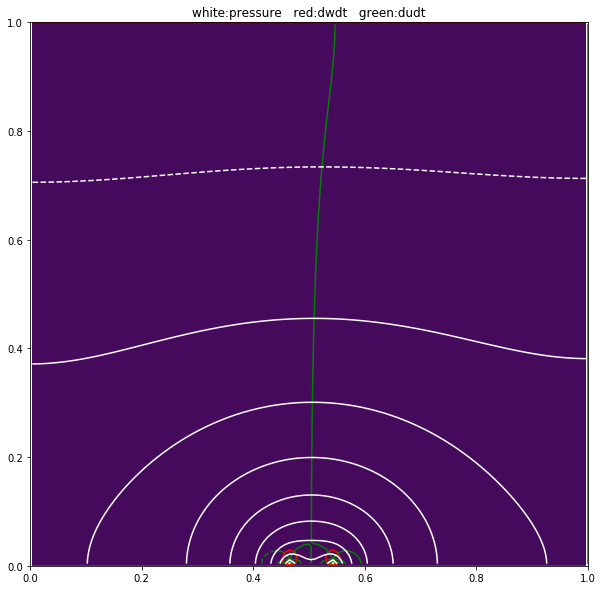

In [16]:
# Look at how pressure enforces non-divergence
# as the buoyant blob starts to rise.
quick,simple = plt.subplots(figsize=(10,10))
simple.contourf(xb,zb,bi,20) 
simple.contour(xw,zw,dwdt,10,colors=['r',]) 
simple.contour(xu,zu,dudt,10,colors=['g',])
simple.contour(xp,zp,p,10,colors=['w',])
simple.set_title('white:pressure   red:dwdt   green:dudt');

<hr/>
## Set up the animation plot:

In [17]:
# specify paramters for the animation plot
vd = 4 # vector skip in arrow plots (vd=1 would plot all arrows)

buoylevs = np.linspace(-.05,1.05,12)
buoylevs[0] = -.25  # extend level to prevent advection errors going off the scale
buoylevs[-1] = 1.25 # extend level to prevent advection errors going off the scale
print('contour levels for buoyancy:',buoylevs)

preslevs = np.linspace(-.4,.4,81)
print('contour levels for pressure:',preslevs)

vortamp = 40 # for possible plotting of vorticity, change vortamp as needed
vortlevs = np.linspace(-1.05*vortamp,1.05*vortamp,22)
print('contour levels for vorticity:',vortlevs)

contour levels for buoyancy: [-0.25  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.25]
contour levels for pressure: [-0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29
 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17
 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05
 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07
  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19
  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31
  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.4 ]
contour levels for vorticity: [-42. -38. -34. -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.
  14.  18.  22.  26.  30.  34.  38.  42.]


In [18]:
myfig = plt.figure(figsize=(10,10),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8], frameon=False) # contour axes
ax3 = myfig.add_axes([0.0, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
ax2.axis('off')
plt.setp( ax2.get_xticklabels(), visible=False);
plt.close()
cbar_exists = False

In [19]:
def doplot():
    global cbar_exists
    matplotlib.rcParams.update({'font.size': 22})
    ax2.clear()
    CF = ax2.contourf(xb,zb,b,buoylevs,zorder=2)
    # plot either vort or p:
    #vort = vortU(u,w,dx,dz)
    #ax2.contour(xU,zU,vort,vortlevs,colors=('w',),zorder=4)
    ax2.contour(xp,zp,p,preslevs,colors=('w',),zorder=4)
    ax2.axis('off')
    up = u_to_p(u)
    wp = w_to_p(w)
    Q = ax2.quiver(xp[::vd,::vd],zp[::vd,::vd],up[::vd,::vd]*zmax/xmax,wp[::vd,::vd],
            scale=0.5*speedmax*Nx/vd,units='width',zorder=3)
    ax2.text(.5,-.05,expt,fontsize=18)
    ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=22)
    speedf = "%7.3f"  % speedmax
    stop_clipping(ax2)
    ax2.quiverkey(Q,-.1,.95,speedmax,speedf,zorder=4)
    if not cbar_exists:
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
        cbar_exists = True
        
    clear_output(wait=True)
    display(myfig)
    
    if outdir: 
        timestamp = 100*round(t,2)
        pngname = outdir+'/%06d.png' % round(timestamp) 
        myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')

<hr/>
## Set parameters for the numerical solution:

In [20]:
outdir = 'bubble_buoyancy2jets_d10' # set = to a directory name, if you want to save png, = None if not.
if outdir and not os.path.exists(outdir): os.mkdir(outdir)

In [21]:
speedmax = 1.0 # estimated maximum speed that will occur
cfl = .3 # if parcel moves at speedmax, fraction of dx it is allowed to traverse 
dt = cfl*dx/speedmax # restrict dt by cfl choice
div_reduce = 0. # try 0.1
aborder = 3 # Adams-Bashforth order: 1, 2 or 3
expt = '%d,%d,%4.2f,%7.5f' % (Nx, nexp, cfl, diffusion_coef)
print(expt)

129,25,0.30,0.00000


<hr>
##  Start from t=0:

In [22]:
u = 0.*xu
w = 0.*xw
p = 0.*xp
b = bi.copy()

dudta = [None]*3
dwdta = [None]*3
dbdta = [None]*3 

nstep = 0

vstore1 = []
vstore2 = []
vstore3 = []
vstore4 = []
tstore = []

t=0. 

#doplot()

<hr/>
## Run the model:


In [23]:
tstop = 5
dplot = .1 # time between plots
tplot = t # time for next plot 

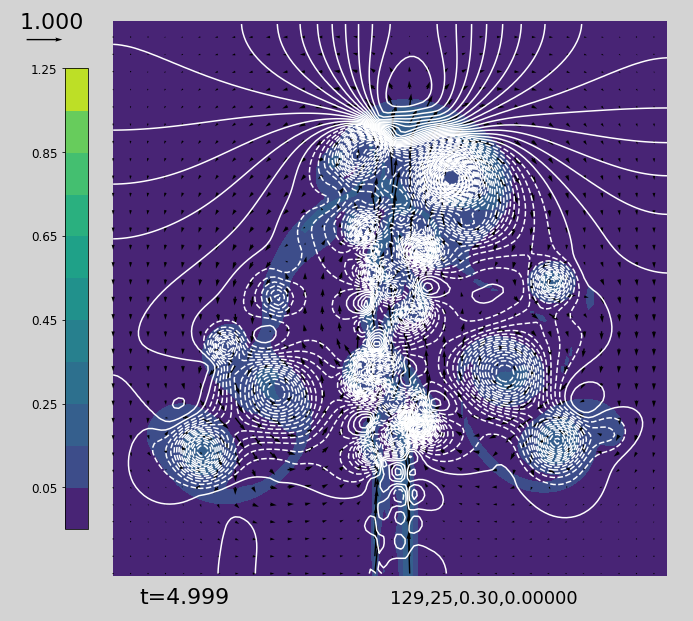

In [24]:
#%%prun 
# remove the above comment symbol to use %%prun
    
while t < tstop - dt/2. :
    nstep += 1
    abnow = min(nstep,aborder) 
    
    div_vel = divergence(u,w,dx,dz)
    wu = w_to_u(w)
    uw = u_to_w(u)
    dbdt = advect(b,uw,w,dx,dz) 
    dudt = advect(u,u,wu,dx,dz)
    dwdt = advect(w,uw,w,dx,dz) + b
    if diffusion_coef > 0.0 :
        dbdt += diffusion_coef*laplacian(b,dx,dz,il=0,ir=-1)
        dudt += diffusion_coef*laplacian(u,dx,dz,jb=0,jt=-1)
        dwdt += diffusion_coef*laplacian(w,dx,dz,il=0,ir=-1)
    div_accel = divergence(dudt,dwdt,dx,dz)
    p = poisson_p_fft(div_accel + div_reduce*div_vel/dt  , invlapl)
    p -= p.mean()
    dudt[:,1:-1] += (p[:,:-1]-p[:,1:])/dx
    dwdt[1:-1,:] += (p[:-1,:]-p[1:,:])/dz
       
    dudta = [dudt.copy()] + dudta[:-1]
    dwdta = [dwdt.copy()] + dwdta[:-1]
    dbdta = [dbdt.copy()] + dbdta[:-1]
    
    u += dt*ab_blend(dudta,abnow) 
    w += dt*ab_blend(dwdta,abnow)
    b += dt*ab_blend(dbdta,abnow)
        
    t = t + dt
    
    vstore1.append( b.max() )
    vstore2.append( abs(div_vel).max())
    tstore.append(t)
    
    assert u.max()<2.e10, 'kaboom!'
       
    if t > tplot - dt/2. : 
        doplot()
        tplot = min(tstop,tplot + dplot)

plt.close() 

In [25]:
import glob 
import imageio

path = "/Users/willytsai/ATM663_convection_meso/Assignments/Notebooks/"+outdir
os.chdir(path)
filenames = sorted(glob.glob('*.png'))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./bubble_exp.gif', images) # convert plots into a gif movie

## 2D convection comparison: Starting plume cases
###  < Bouyancy jet >: boundary layer flow originating from a source of buoyancy and momentum
### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$(Left) Control run  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ (Right) Triple momentum wx3

<tr>
<td><img src='./bubble_buoyancyjet/bubble_exp.gif' width="400" height="400"><td>
<td><img src='./bubble_buoyancyw3/bubble_exp.gif' width="400" height="400"><td>
<tr>

### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$(Left) Control run  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ (Right) Mutiple sources

<tr>
<td><img src='./bubble_buoyancyjet/bubble_exp.gif' width="400" height="400"><td>
<td><img src='./bubble_buoyancy3jets/bubble_exp.gif' width="400" height="400"><td>
<tr>

### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Distance between two buoyancy & momentum sources
### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$(Left) Control run  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ (Right) half distance
#### shorter distance between two sources fastenes the interaction among plumes

<tr>
<td><img src='./bubble_buoyancy2jetctrl/bubble_exp.gif' width="400" height="400"><td>
<td><img src='./bubble_buoyancy2jet_d10/bubble_exp.gif' width="400" height="400"><td>
<tr>

In [26]:
diffusion_coef

0.0

0.3 0.24545905856150008


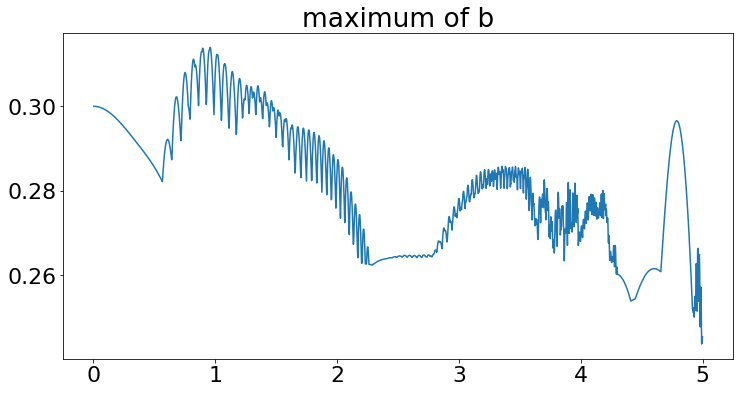

In [27]:
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore1)
simple.set_title('maximum of b')
print(vstore1[0],vstore1[-1])

0.0 0.02930425615407195


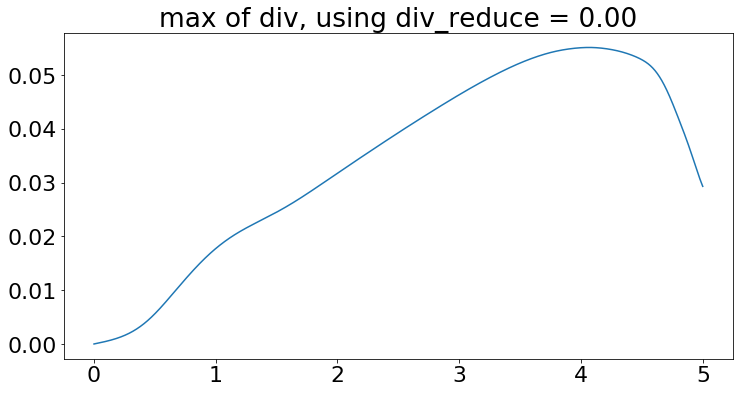

In [28]:
quick,simple = plt.subplots(figsize=(12,6))
simple.plot(tstore,vstore2)
df = '%5.2f' % div_reduce
simple.set_title('max of div, using div_reduce ='+df )
print(vstore2[0],vstore2[-1])

<hr/>
## Student tasks:

### 1.  The Poisson solver

Suppose that you know the accelerations, except for pressure-gradient force,
that contribute to convergence and divergence of the velocity field.
You therefore know the desired $\lapl P$ of the required field of $P(x,y,t)$.
Suppose your FFTs have yielded $A_{k,m}$ in:

$$
\lapl P(x,y) = \sum_{k,m} A_{k,m} \cos(kx)\cos(my)
$$

derive the expression for the coefficients $B_{k,m}$ in

$$
P(x,y) = \sum_{k,m} B_{k,m} \cos(kx)\cos(my)
$$

Your expression will be in terms of $A_{k,m}$, $k$ and $m$.

Find both the "easy" expression: the `calculus` option, and the more accurate ones for the `discrete` option.

Show that they become equivalent for small $k$ and $m$.

### 2. Improving nondivergence

However, perhaps we don't want exactly $\pdt{\delta}=0$.
We may need to relieve some residual $\delta$ that has accumulated from many previous time steps.
Set `div_reduce=0.1`, and note any improvement in enforcing $\delta=0$.

Yes, $\delta$ is reduced, but, either way, it is so small as to be inconsequential.

### 3. Get a blob to work in StreamfunctionVorticity.ipynb

You will need to add `b`,`dbdt`, and `dbdta` to **StreamfunctionVorticity.ipynb**.
The vorticity equation needs to include the so-called baroclinic generation term:

$$
\frac{d\zeta}{dt} = \frac{\partial b}{\partial x}
$$

Also the simulation in this notebook does not use vorticity implicitly,
it can be calcuated from $u$ and $w$ and plotted.  See the commented code in `doplot`.
Uncommenting it will give you an idea of what your revised **StreamfunctionVorticity.ipynb** needs
to prognosticate.

### 4. Do something fun with buoyancy

Think of your own creative simulation that includes buoyancy. For example, collision of a negative and positive
buoyancy blob. Not necessarily a direct hit.

You can run your simulation with either your stream-function-vorticity notebook, or in a modification of this notebook.

Save your PNG images, and be prepared to present them in class.

### 5. Energetics

#### The volume integral

$$\newcommand{\VI}[1]{\left\langle#1\right\rangle}$$

Let the volume (area) integral over the model domain be denoted as:

$$\VI{q} \equiv \iint q ~ \D x \D z $$

Let's investigate 

$$
\VI{\ddt{q}}
$$

If the flow is incompressible with

$$
\pd{u}{x} + \pd{w}{z} = 0
$$

then

$$
\ddt{q} = \pdt{q} + u \pd{q}{x} + w \pd{q}{z} = \pdt{q} +  \pd{}{x}uq +  \pd{}{z}wq 
$$

So

$$
\VI{\ddt{q}} = \VI{\pdt{q} +  \pd{}{x}uq +  \pd{}{z}wq} 
$$

The volume integral of a sum is the sum of the volume integrals:

$$
\VI{\ddt{q}} = \VI{\pdt{q}} + \VI{\pd{}{x}uq} +  \VI{\pd{}{z}wq} 
$$

The normal component of velocity on the boundaries is zero so last two integrals on the right are zero.
The time derivative in the first integral on the right commutes with the integration:

$$
\VI{\ddt{q}} = \pdt{}\VI{q} 
$$

You will need to use the fact that the normal component of velocity is zero on the boundaries.

#### kinetic energy production

$$
\pdt{u} + u \pd{u}{x} + w \pd{u}{z}= - \pd{P}{x}
$$

$$
\pdt{w} + u \pd{w}{x} + w \pd{w}{z}= - \pd{P}{z} + b
$$

Multiply the first by $u$ and the second by $w$, use incompressibility, and show:

$$
\pdt{}\frac{u^2+w^2}{2} + \pd{}{x} u \frac{u^2+w^2}{2} + \pd{}{z}  w \frac{u^2+w^2}{2} = -\pd{}{x}uP -  -\pd{}{z}wP + wb
$$

Then show:

$$
\pdt{}\VI{\frac{u^2+w^2}{2} } = \VI{wb}
$$

#### potential energy

Given $\ddt{b}=0$:

$$
\VI{wb} = \VI{\ddt{z}b} = \VI{\ddt{}bz} = \pd{}{t}\VI{bz}
$$

Thus

$$
\pdt{}\VI{\frac{u^2+w^2}{2} - bz } = 0
$$

The integral is total energy `E` in the model. The integral of  first term is kinetic energy `KE` and of the second term is potential energy `PE`.
In our Python model, it would be best to interpolate $u$ and $v$ to the p-grid to evaluate these integrals. The volume integral of an array `q` in the p-grid would be simply `q.sum()*dx*dz`.  Plot (using the `vstore`'s) that 
though `KE` increases and `PE` decreases, the sum is nearly invariant with time.

